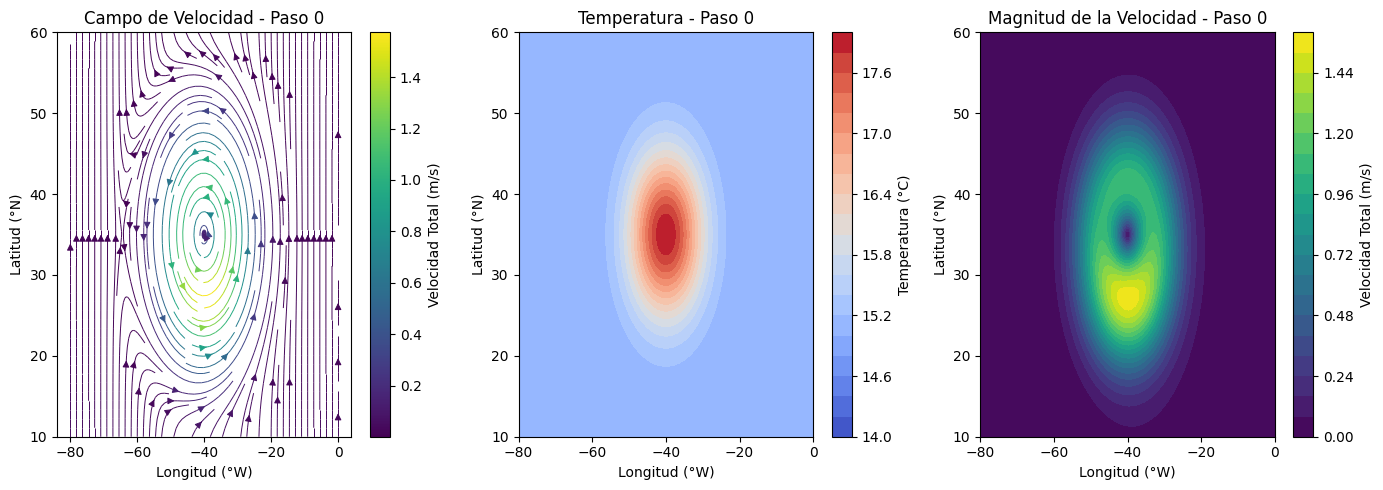

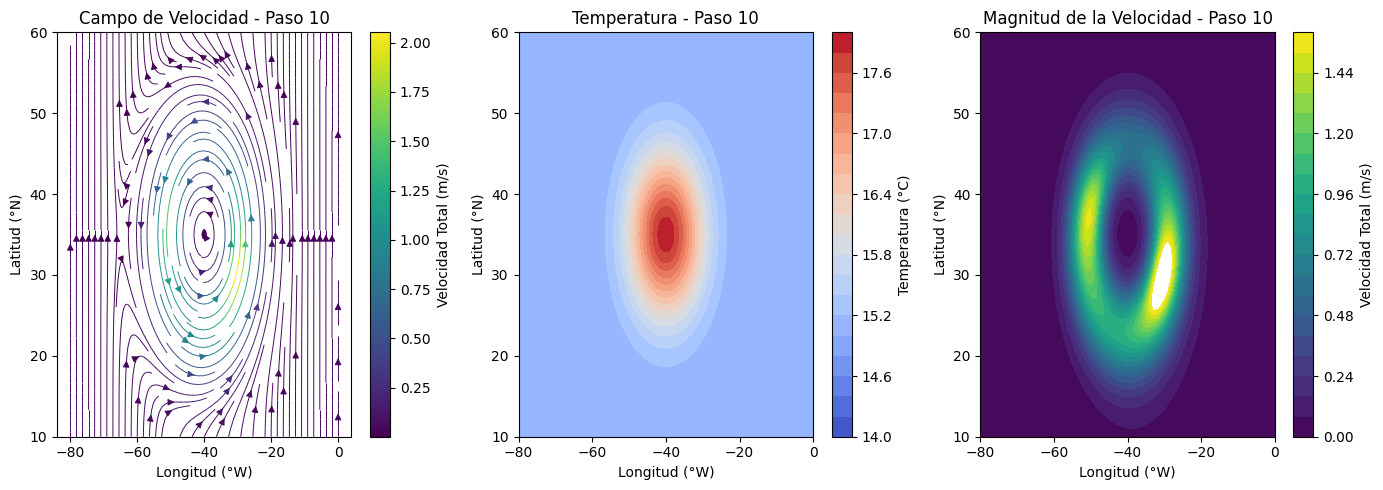

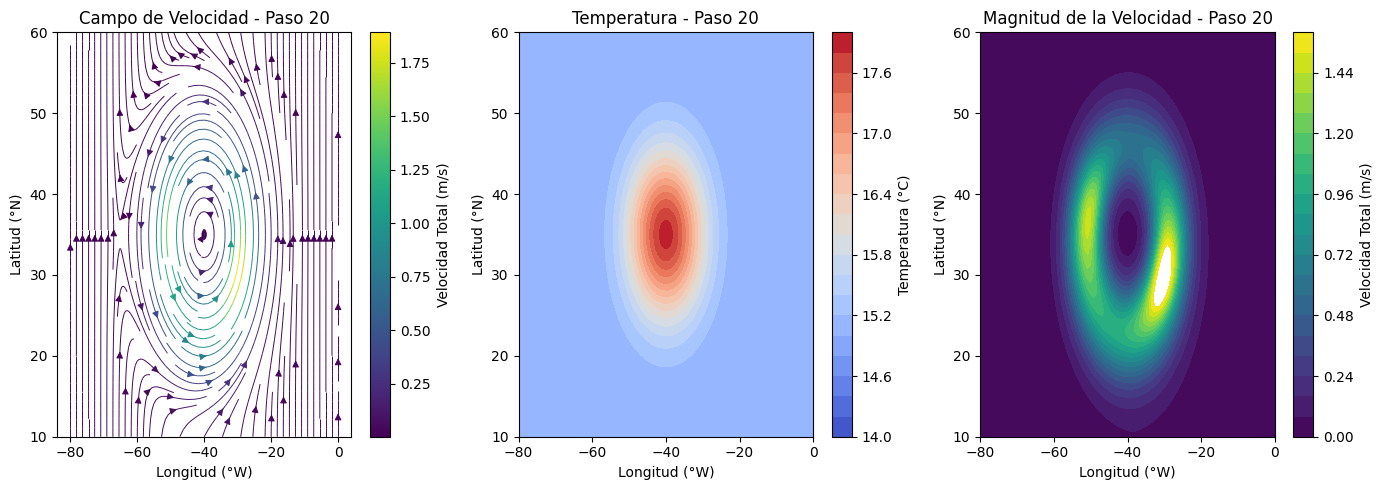

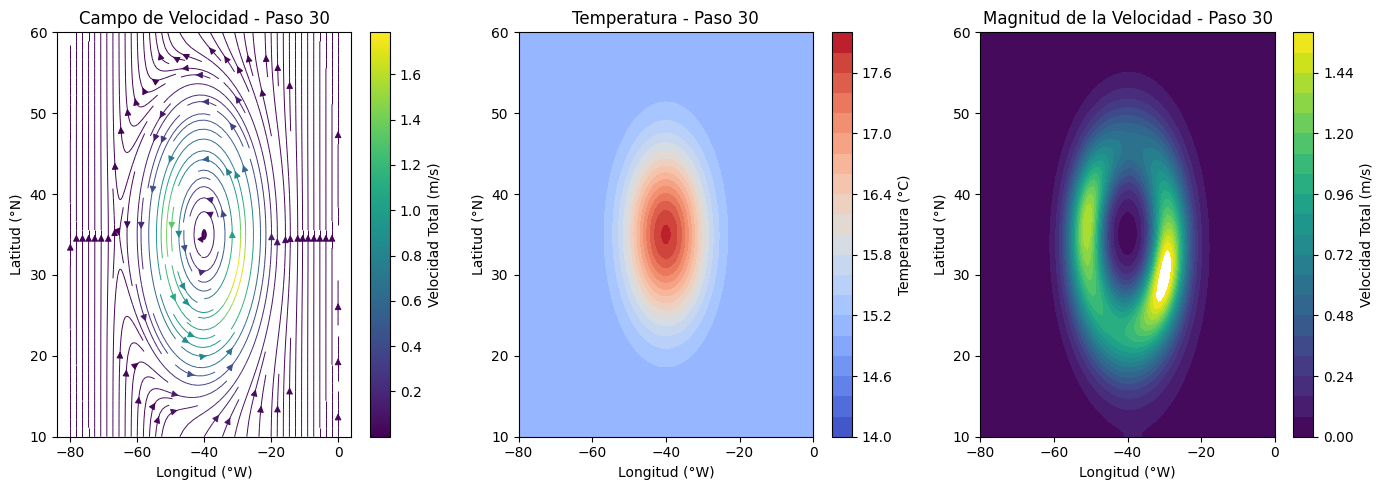

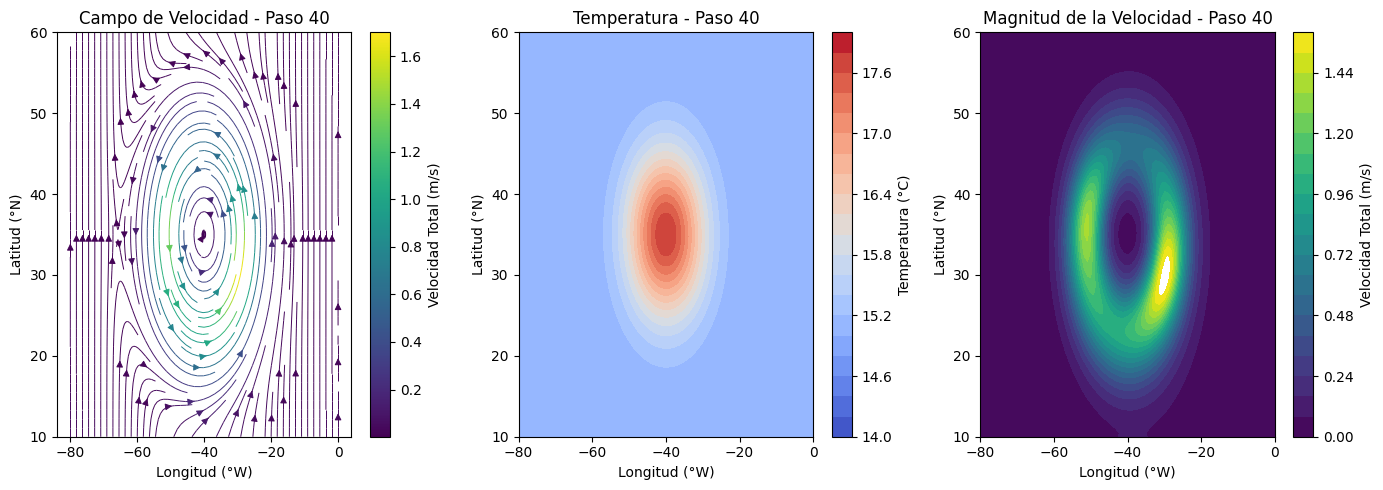

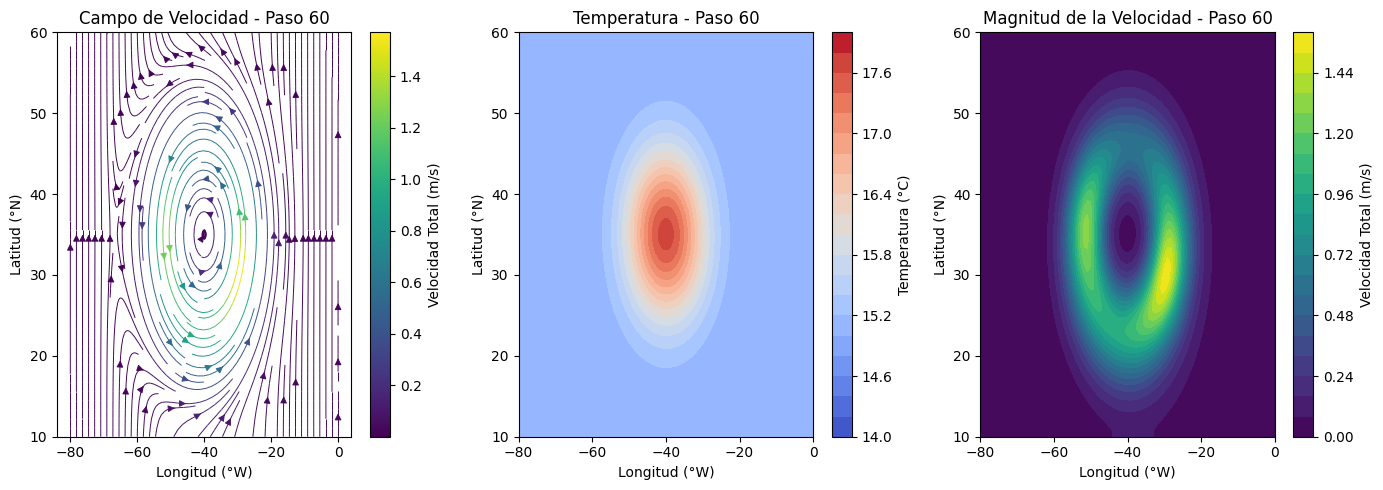

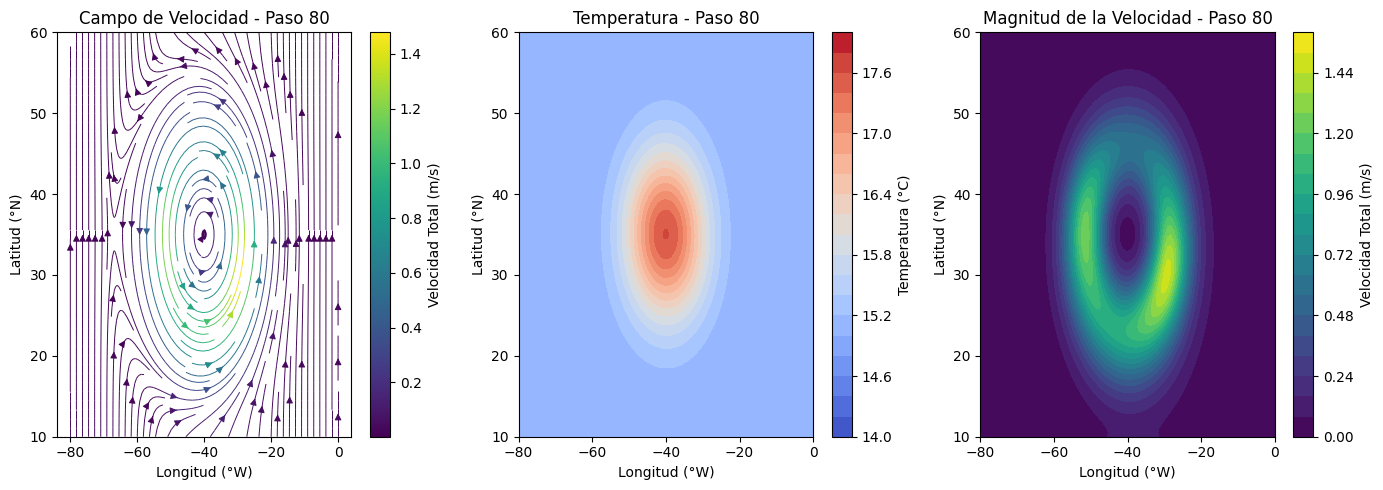

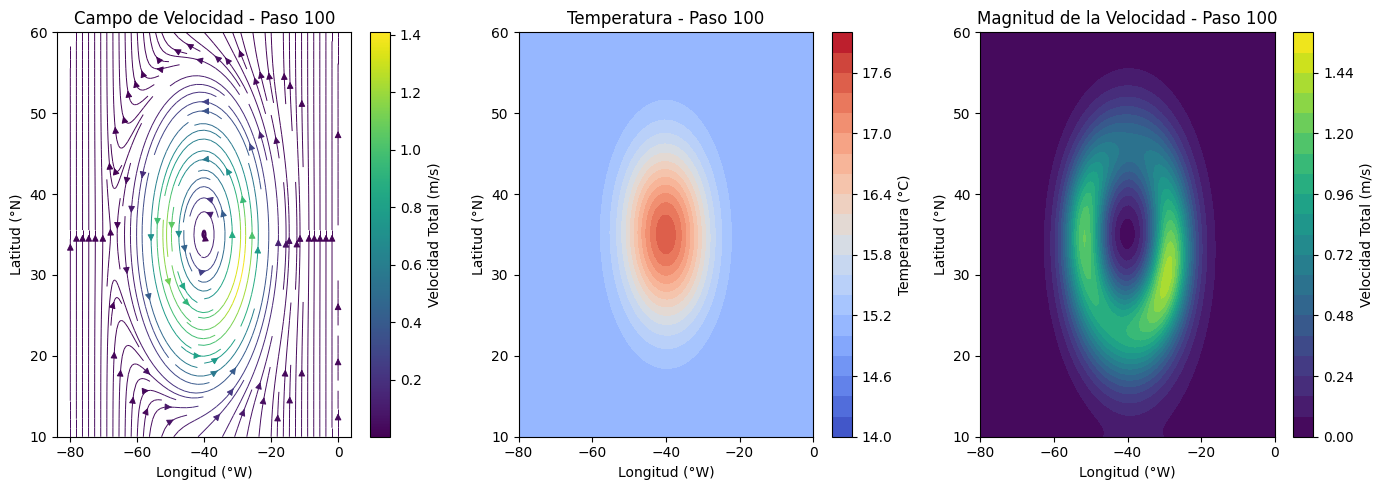

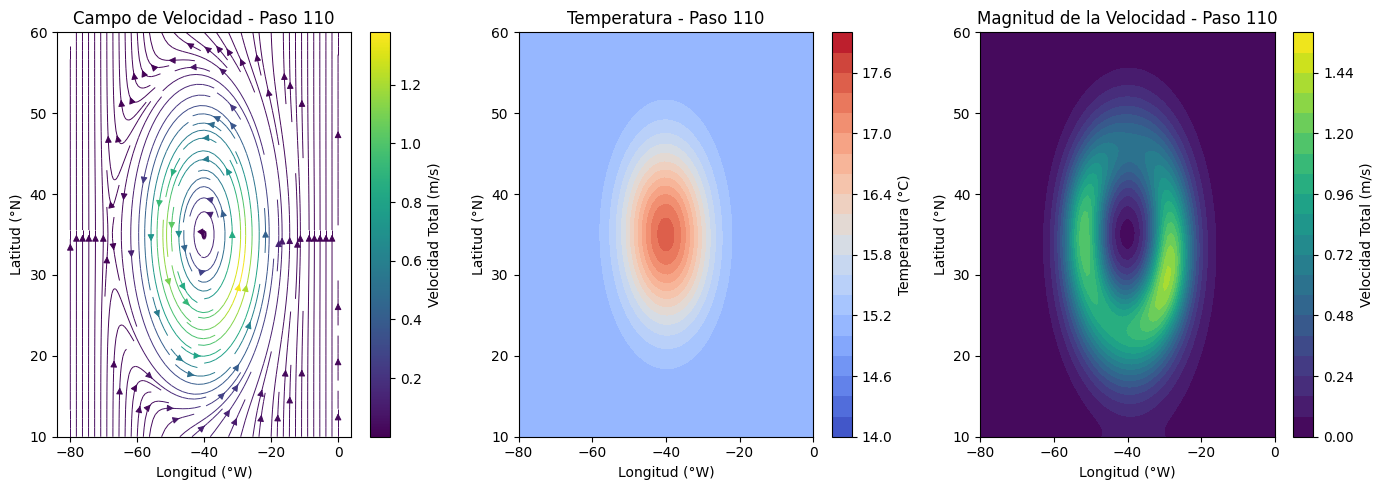

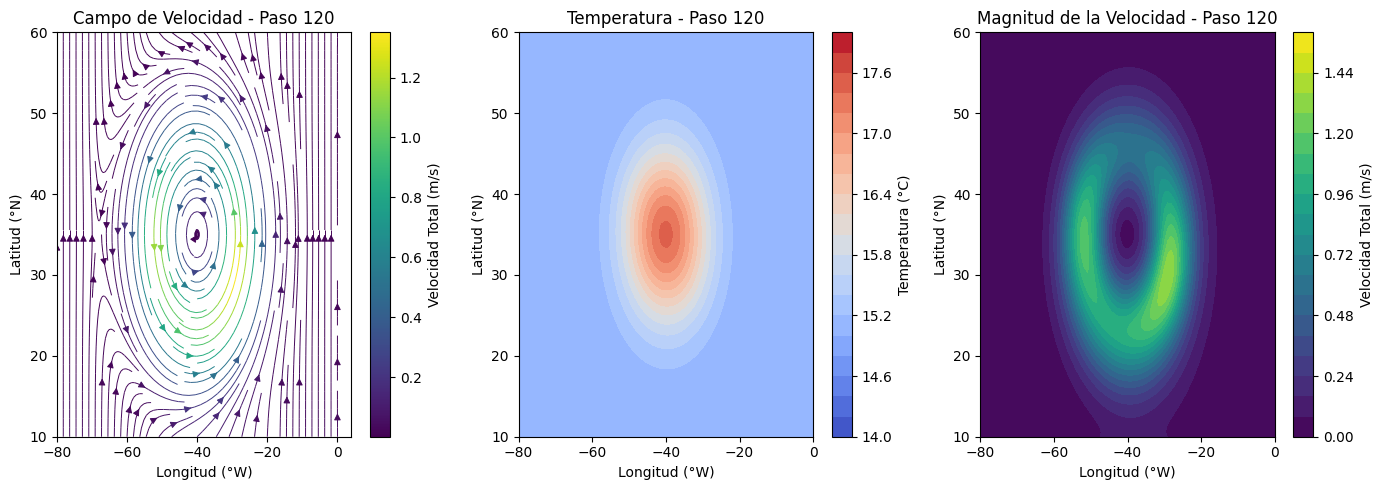

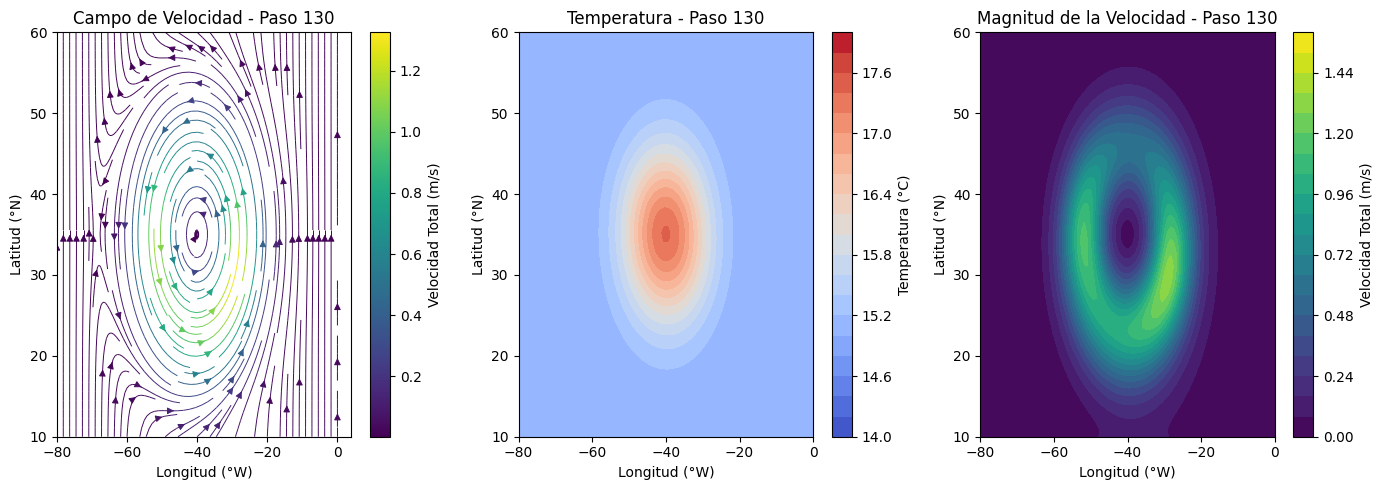

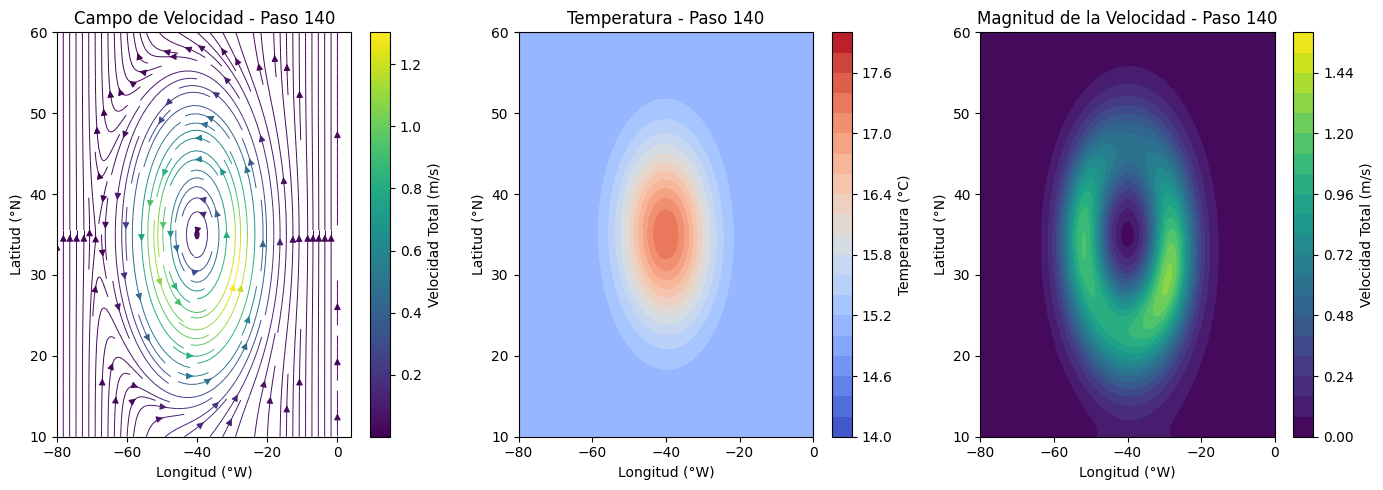

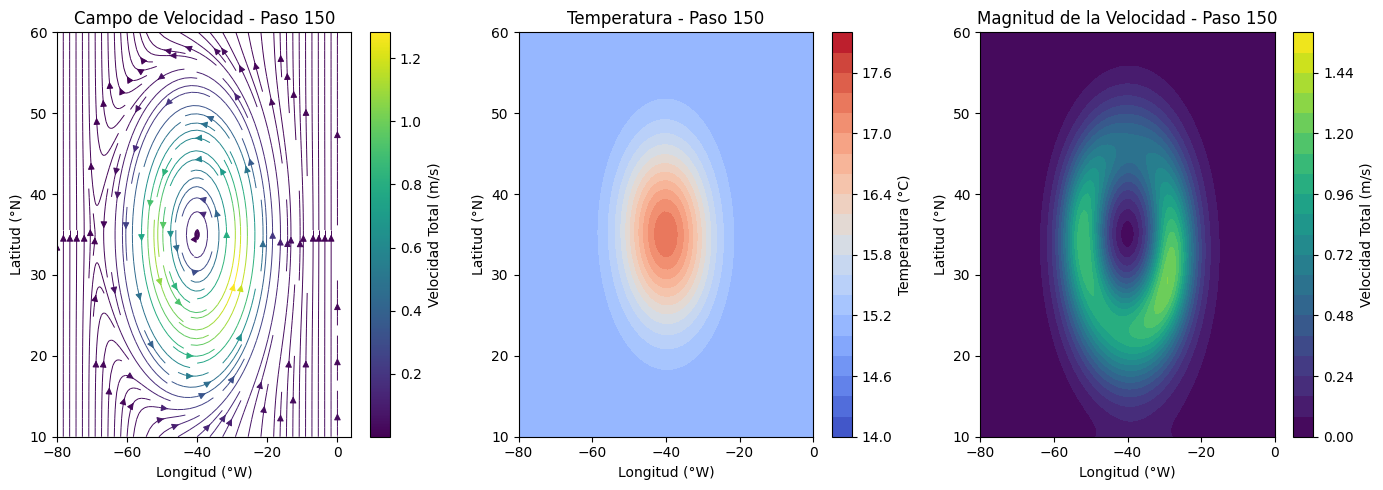

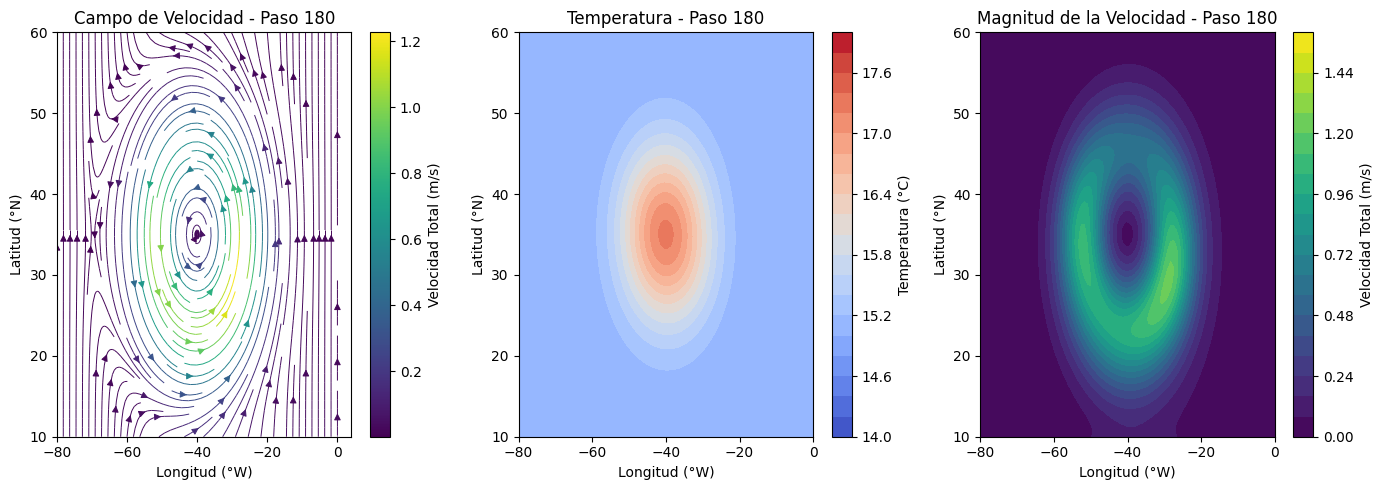

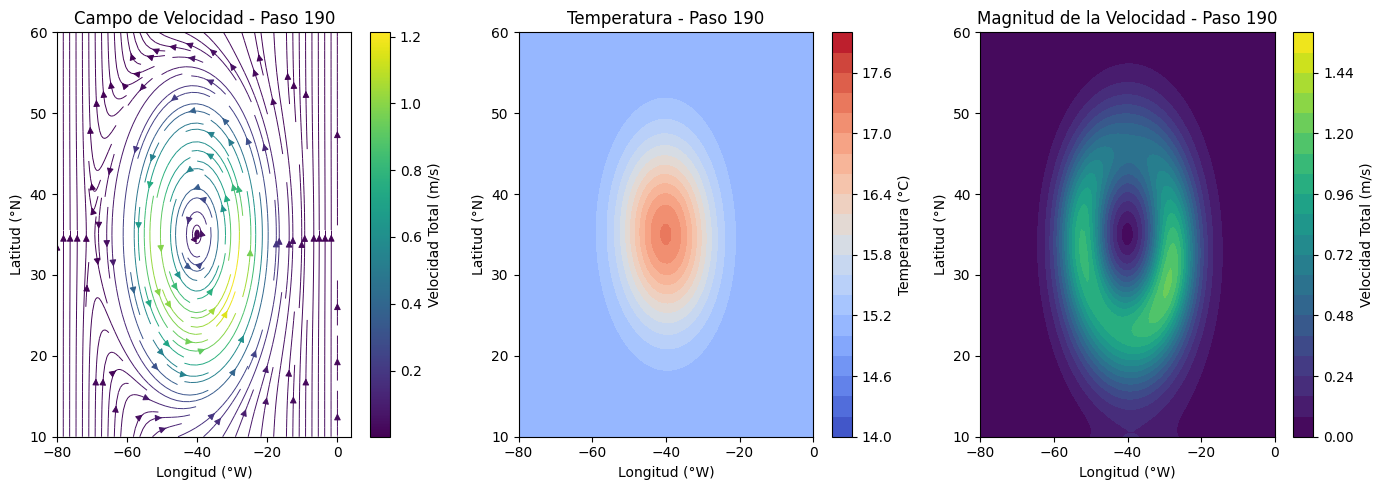

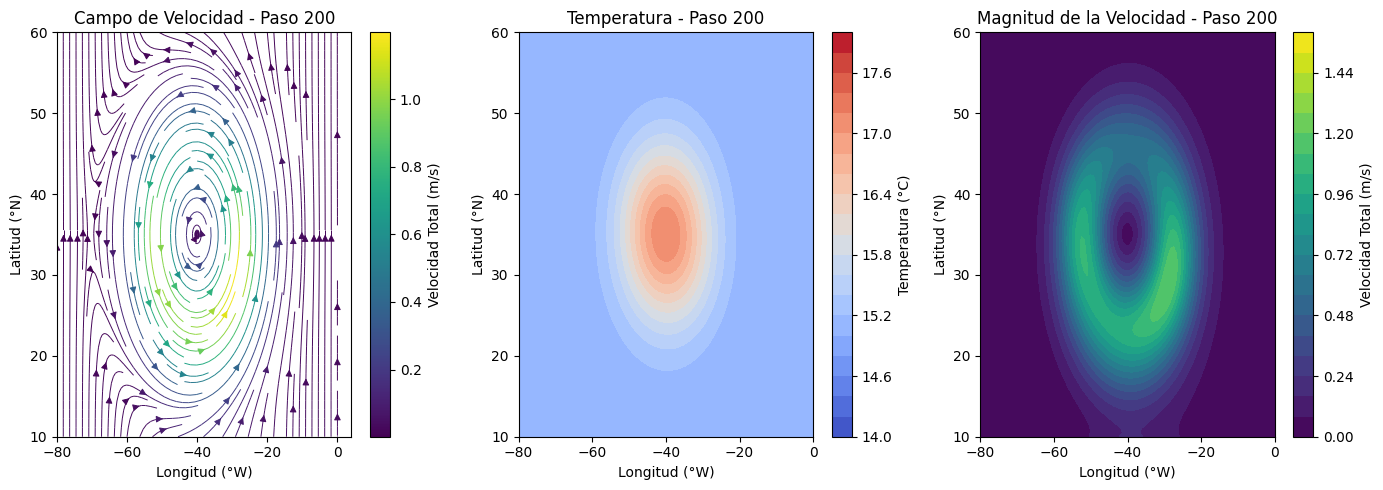

Disipación total paso 200: 24437871634.843185


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Parámetros
dx = 1  # Paso espacial
dy = 1
dt = 0.1  # Paso temporal
steps = 210  # Número de pasos de simulación
rho0 = 1025  # Densidad base (kg/m^3)
T0 = 15  # Temperatura base (°C)
P0 = 1000  # Presión base (Pa)
a = 0.03  # Coeficiente de densidad respecto a T
b = 1  # Coeficiente de presión respecto a rho
c=0.01 #derivada de v respecto rho
d=0.01 #derivada de v respecto P
beta = 0.001  # Parámetro de evolución de densidad
gamma = 0.001  # Parámetro de evolución de presión
D = 1  # Coeficiente de difusión térmica
alpha = 0.05  # Parámetro de evolución de velocidad
model = "linear"  # Modelo de gradiente
lat_scale = 35  # Escala para la dependencia en latitud
lon_scale = 40  # Escala para la dependencia en longitud
Omega = 7.2921e-5  # Velocidad angular de la Tierra (rad/s)
profundidad=100
nx, ny = 100, 100 # Dimensiones de la malla
latitudes = np.linspace(10, 60, nx)
longitudes = np.linspace(-80, 0, ny)
X, Y = np.meshgrid(longitudes, latitudes)


# Inicialización de los campos
temperature = T0 * np.ones((nx, ny))
density = rho0 * np.ones((nx, ny))
pressure = P0 * np.ones((nx, ny))
velocity_x = np.ones((nx, ny)) 
velocity_y = np.ones((nx, ny))  

# Parámetros de la perturbación gaussiana
A = 3 
sigma_x = 7  
sigma_y = 7 
lat0 = (latitudes[0] + latitudes[-1]) / 2
lon0 = (longitudes[0] + longitudes[-1]) / 2
temperature += A * np.exp(-((X - lon0)**2 / (2 * sigma_x**2) + (Y - lat0)**2 / (2 * sigma_y**2))) 

# Frecuencia de Coriolis 
f = 2 * Omega * np.sin(np.deg2rad(Y))

# Viento 
U = -10 * np.ones(Y.shape) 
V = np.zeros(Y.shape) 

# Esfuerzo del viento
Cd = 1.2e-3  
tau_x = Cd * U**2 * np.sign(U)
tau_y = Cd * V**2 * np.sign(V)

def calculate_pressure_gradient(X, Y, P0, new_density, model="linear", lat_scale=40, lon_scale=20):
    if model == "exponential":
        grad_P_y = -P0 * np.exp(-(Y - lat_scale) / lat_scale)
        grad_P_x = P0 * np.exp(-(X + lon_scale) / lon_scale)
    elif model == "linear":
        delta_t = (new_density - rho0)
        P_prime = delta_t
        grad_P_y = - P_prime*P0 * (Y - lat_scale) / lat_scale
        grad_P_x = (X + lon_scale) / lon_scale * P0 *P_prime
    elif model == "sinusoidal":
        grad_P_y = -P0 * np.sin(np.deg2rad(Y / lat_scale))
        grad_P_x = P0 * np.cos(np.deg2rad(X / lon_scale))
    else:
        raise ValueError(f"Modelo de presión '{model}' no reconocido.")
    return grad_P_x, grad_P_y

def laplacian(field, dx, dy):
    return (np.roll(field, 1, axis=0) + np.roll(field, -1, axis=0) +
            np.roll(field, 1, axis=1) + np.roll(field, -1, axis=1) -
            4 * field) / (dx**2)

def advection(field, velocity_x, velocity_y, dx, dy, dt):
    """ Calcula la advección de un campo escalar dado un campo de velocidad """
    dTdx = (field - np.roll(field, 1, axis=1)) / dx
    dTdy = (field - np.roll(field, 1, axis=0)) / dy
    return -velocity_x * dTdx * dt - velocity_y * dTdy * dt

def vx(P, rho, dT_dt, beta, alpha, b, P0, rho0, f, tau_y, grad_P_y):
    rho_P = (P - P0) / b + rho0
    numerador = tau_y + grad_P_y
    A_P = (1 / (profundidad*f)) * (numerador / rho_P) * (beta * rho_P) ** (-alpha / beta)
    return A_P * (beta * rho + dT_dt) ** (alpha / beta)

def vy(P, rho, dT_dt, beta, alpha, b, P0, rho0, f, tau_x, grad_P_x):
    rho_P = (P - P0) / b + rho0
    numerador = -tau_x + grad_P_x
    A_P = (1 / (profundidad*f)) * (numerador / rho_P) * (beta * rho_P) ** (-alpha / beta)
    return A_P * (beta * rho + dT_dt) ** (alpha / beta)

def update_system(temperature, density, pressure, velocity_x, velocity_y,
                  dx, dy, dt, D, a, b, beta, gamma, alpha,
                  rho0, P0, T0,
                  f, tau_x, tau_y, grad_P_x, grad_P_y, dT_dt):
   
    lap_T = laplacian(temperature, dx, dy)

    adv_T = advection(temperature, velocity_x, velocity_y, dx, dy, dt)

    new_temperature = temperature + (D * lap_T + adv_T) * dt

    new_density = rho0 + a * (new_temperature - T0)

    new_pressure = P0 + b * (new_density - rho0)
    
    grad_P_x, grad_P_y = calculate_pressure_gradient(X, Y, P0, new_density, model=model, lat_scale=lat_scale, lon_scale=lon_scale)
    
    new_density += dt * (
        -velocity_x * (new_density - np.roll(new_density, 1, axis=0)) / dx
        -velocity_y * (new_density - np.roll(new_density, 1, axis=1)) / dy
        + beta * new_density
    )

    new_pressure += dt * (
        -velocity_x * (new_pressure - np.roll(new_pressure, 1, axis=0)) / dx
        -velocity_y * (new_pressure - np.roll(new_pressure, 1, axis=1)) / dy
        + gamma * new_pressure
    )

    new_velocity_x = vx(new_pressure, new_density, dT_dt, beta, alpha, b, P0, rho0, f, tau_y, grad_P_y)
    new_velocity_y = vy(new_pressure, new_density, dT_dt, beta, alpha, b, P0, rho0, f, tau_x, grad_P_x)

    return new_temperature, new_density, new_pressure, new_velocity_x, new_velocity_y

previous_temperature = temperature.copy()
grad_P_x = np.zeros_like(X)
grad_P_y = np.zeros_like(Y)
for step in range(steps):
    
    dT_dt = (temperature - previous_temperature) / dt
    previous_temperature = temperature.copy()
    
    temperature, density, pressure, velocity_x, velocity_y = update_system(
        temperature, density, pressure, velocity_x, velocity_y,
        dx, dy, dt, D, a, b, beta, gamma, alpha,
        rho0, P0, T0,
        f, tau_x, tau_y, grad_P_x, grad_P_y, dT_dt
    )
 
    if step % 10 == 0:
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 3, 1)
        speed = np.sqrt(velocity_x**2 + velocity_y**2)
        plt.streamplot(X, Y, velocity_x, velocity_y, color=speed, cmap="viridis", density=1.5, linewidth=0.7, arrowsize=1)
        plt.colorbar(label="Velocidad Total (m/s)")
        plt.title(f"Campo de Velocidad - Paso {step}")
        plt.xlabel("Longitud (°W)")
        plt.ylabel("Latitud (°N)")

        plt.subplot(1, 3, 2)
        plt.contourf(X, Y, temperature,levels=np.linspace(14, 18, 21),cmap='coolwarm')
        plt.colorbar(label='Temperatura (°C)')
        plt.title(f'Temperatura - Paso {step}')
        plt.xlabel("Longitud (°W)")
        plt.ylabel("Latitud (°N)")
        
        plt.subplot(1, 3, 3)
        plt.contourf(X, Y, np.sqrt(velocity_x**2 + velocity_y**2), levels=np.linspace(0, 1.6, 21), cmap="viridis") #levels=np.linspace(0, 1.6, 21)
        plt.colorbar(label="Velocidad Total (m/s)")
        plt.title(f"Magnitud de la Velocidad - Paso {step}")
        plt.xlabel("Longitud (°W)")
        plt.ylabel("Latitud (°N)")
        plt.tight_layout()
        plt.show()

        if step == 5:
            centro_lon = -40
            centro_lat = 35
            deg2m = 111000  
    
            r_i = np.sqrt((X - centro_lon)**2 + (Y - centro_lat)**2) * deg2m
            l_i = 2 * np.pi * r_i
            velocidad_magnitud = np.sqrt(velocity_x**2 + velocity_y**2)
            P_i = velocidad_magnitud * l_i

            np.save("C:\\Users\\Ana\\Desktop\\Python TFG\\eqsolvariandoalpha05paso0.npy", P_i)

        if step == 200:
            centro_lon = -40
            centro_lat = 35
            deg2m = 111000 
    
            r_i = np.sqrt((X - centro_lon)**2 + (Y - centro_lat)**2) * deg2m
            l_i = 2 * np.pi * r_i
            velocidad_magnitud = np.sqrt(velocity_x**2 + velocity_y**2)
            P_i = velocidad_magnitud * l_i
            print("Disipación total paso 200:", np.sum(P_i))
            np.save("C:\\Users\\Ana\\Desktop\\Python TFG\\eqsolvariandoalpha05paso200.npy", P_i)